In [96]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch

In [4]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki


,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartUTC,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29


In [5]:
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartUTC'>

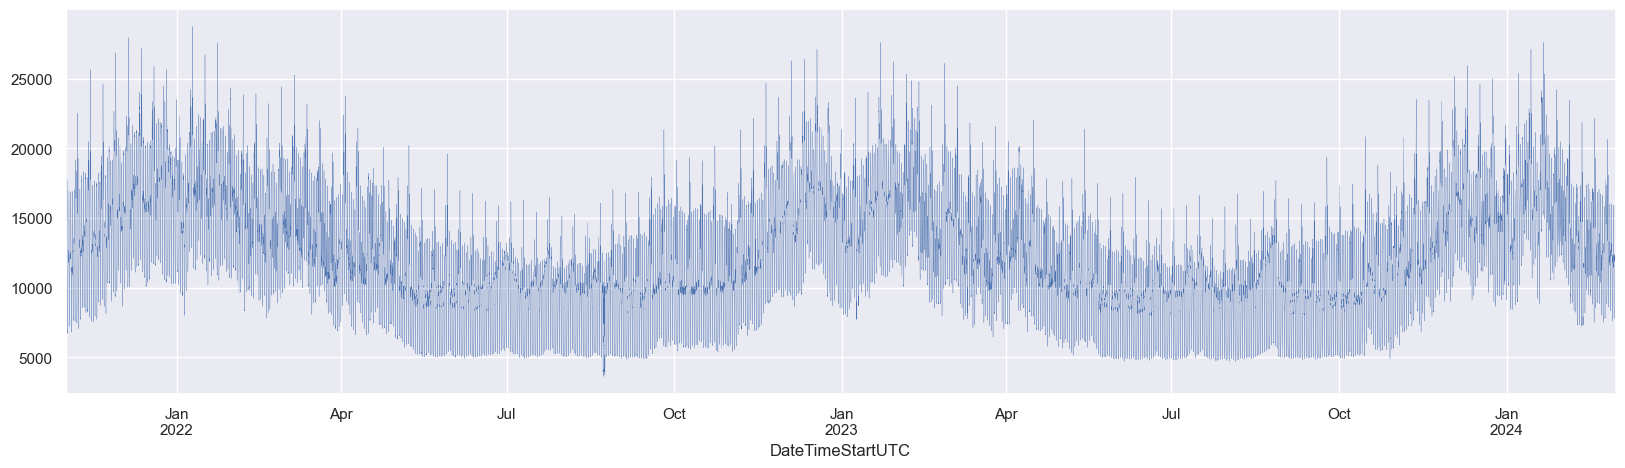

In [6]:
podatki['Odjem ACT'].plot(linewidth=0.2)

In [7]:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()
podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,log return
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.036444
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.034200
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.040203
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.021227
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,0.004812
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:30:00,12529.80,6.85,7.650,0.0,0.0,2024,2,2024-02-29,0.042745
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,0.057346
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,0.048778


<AxesSubplot: xlabel='DateTimeStartUTC'>

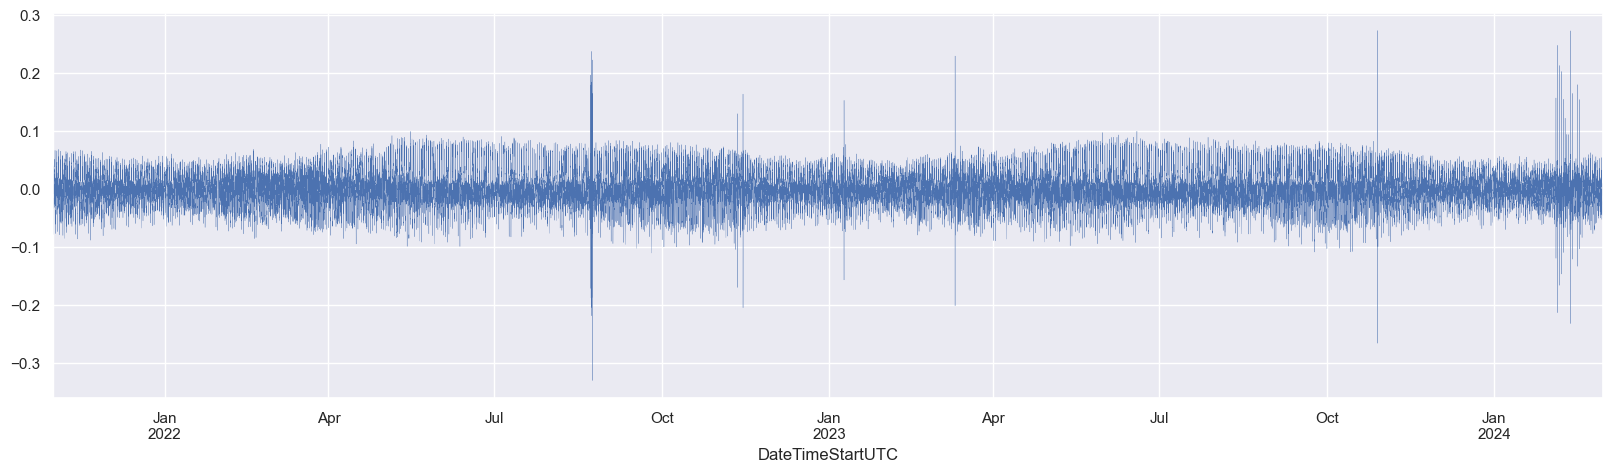

In [8]:
podatki['log return'].plot(linewidth=0.2)
# to je ful bolj stacionarno

In [9]:
from arch.unitroot import *

def preveri_stacionarnost(ts):
    print(ADF(ts).summary())
    print('\n')
    print(KPSS(ts).summary())
    print('\n')
    print(PhillipsPerron(ts).summary())

In [11]:
preveri_stacionarnost(podatki['log return'])

# vsi testi povedo, da je časovna vrsta stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -83.893
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.001
P-value                         1.000
Lags                              133
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.607
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

Text(0.5, 1.0, 'ACF na log return')

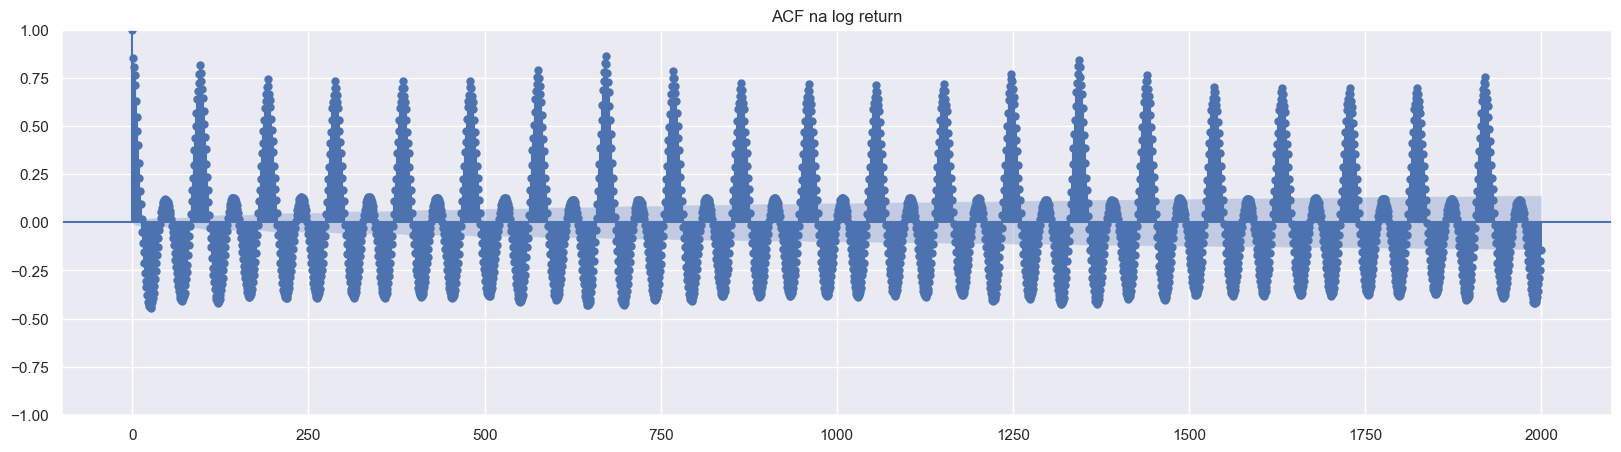

In [14]:
tsaplots.plot_acf(podatki['log return'], lags=1000)
plt.ylim(-1,1)
plt.title('ACF na log return')

# očitno je, da imamo sezonskost, zato sezonsko diferenciramo

Text(0.5, 1.0, 'Log return, ki je sezonsko diferenciran s periodo 96')

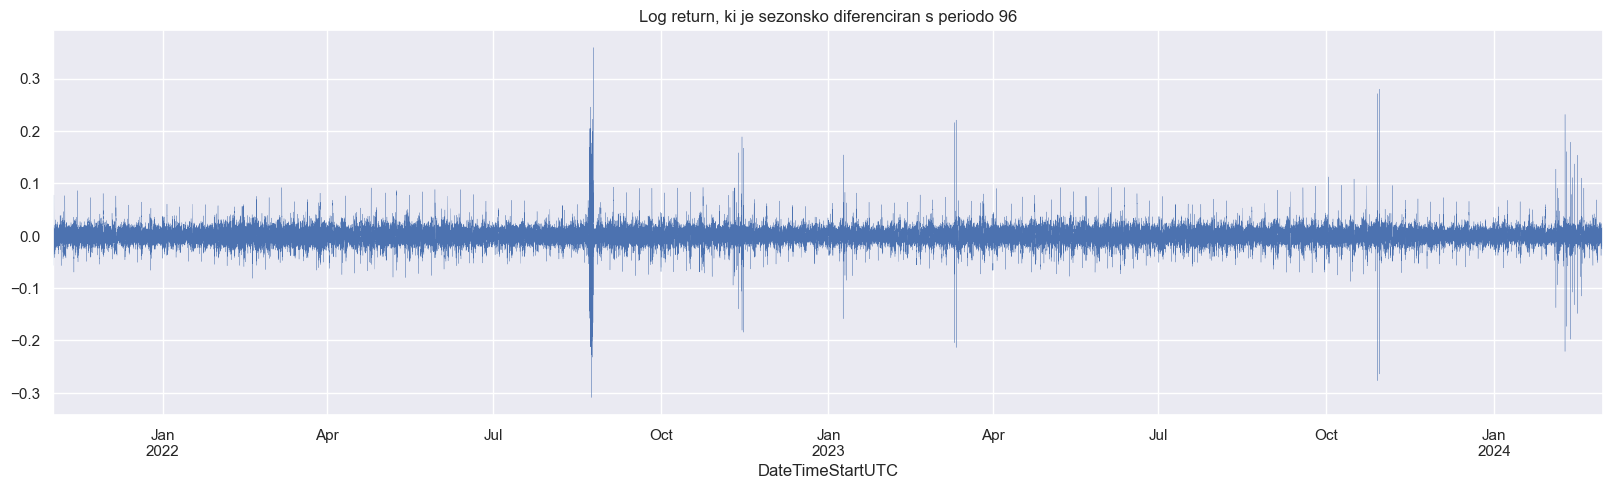

In [21]:
ts_diff = podatki['log return'].diff(periods = 96).dropna()
ts_diff.plot(linewidth=0.2) 
plt.title('Log return, ki je sezonsko diferenciran s periodo 96')

Text(0.5, 1.0, 'ACF na log return')

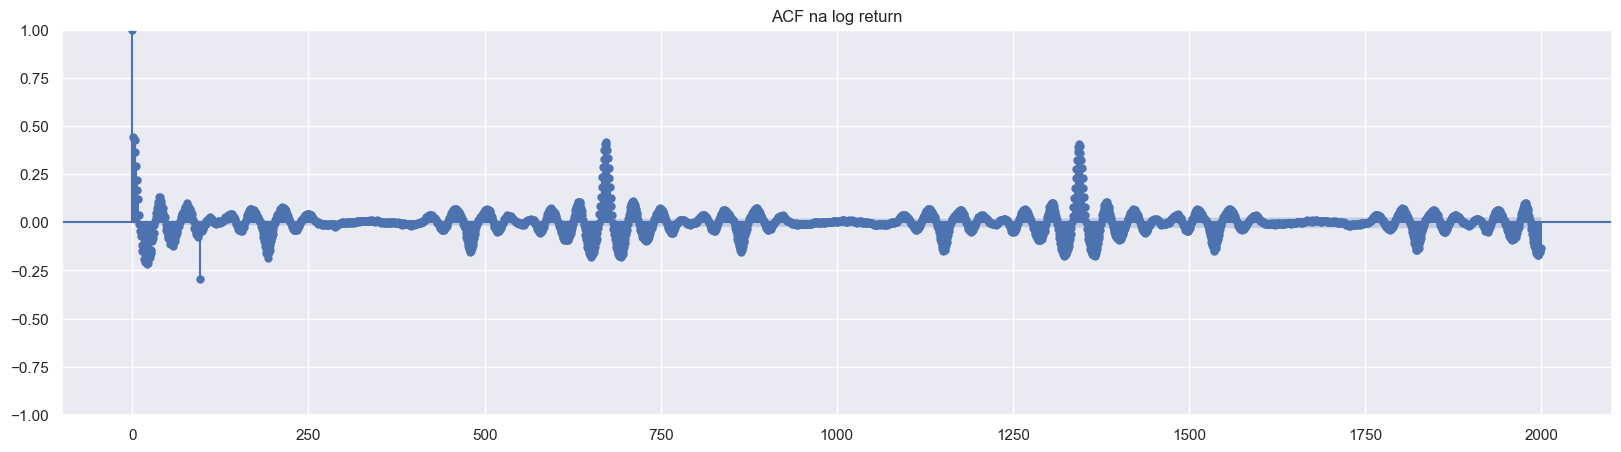

In [17]:
tsaplots.plot_acf(ts_diff, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju')

Text(0.5, 1.0, 'Po drugem diferenciranju')

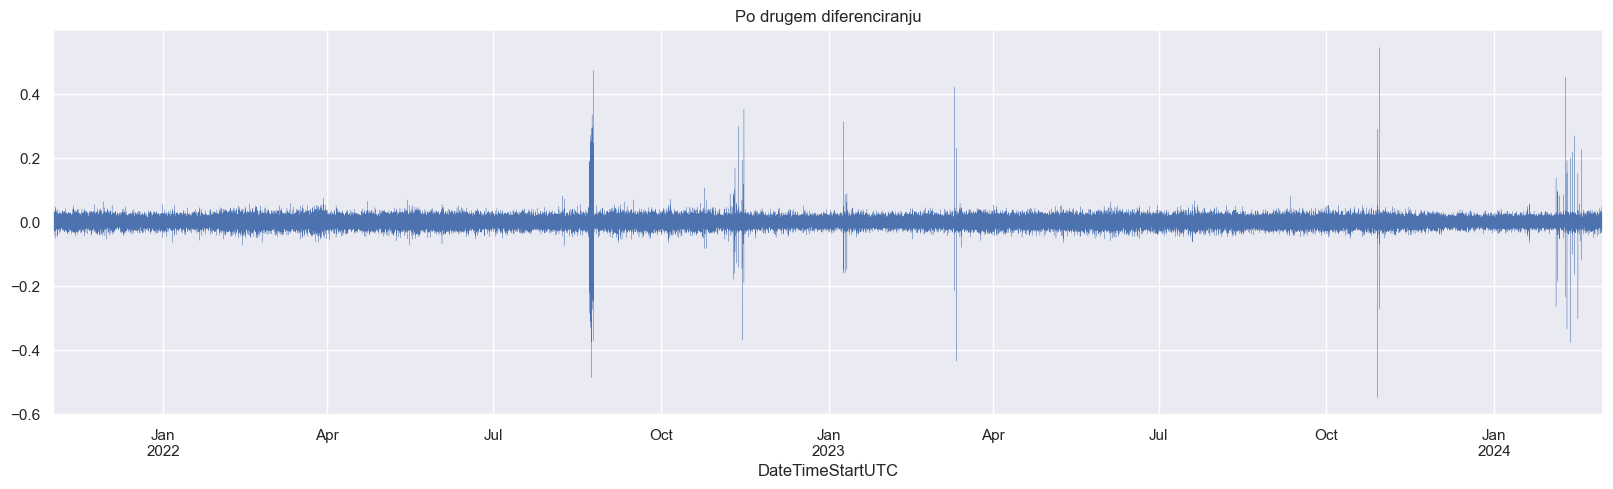

In [18]:
ts_diff_2 = ts_diff.diff().dropna()
ts_diff_2.plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju')

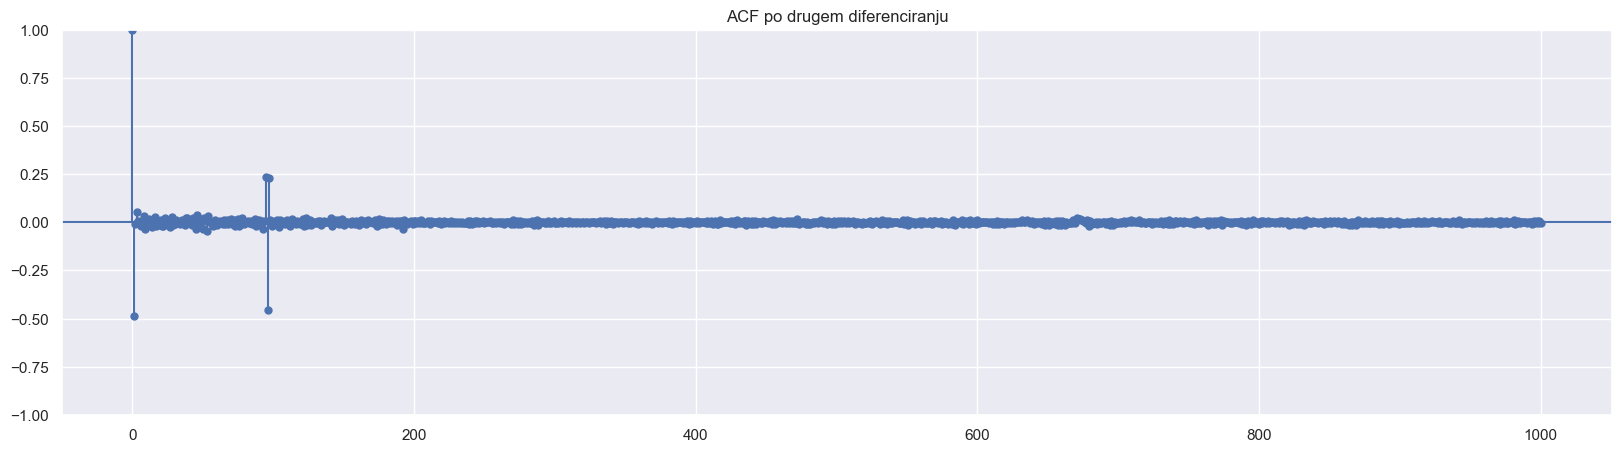

In [24]:
tsaplots.plot_acf(ts_diff_2, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, zoženo')

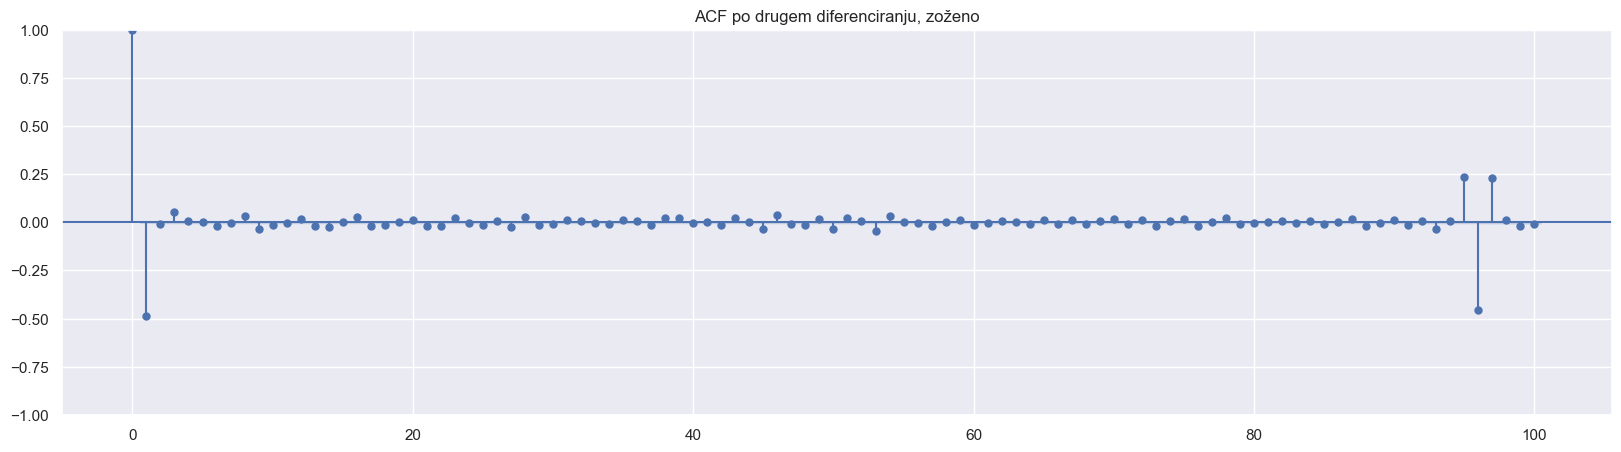

In [26]:
tsaplots.plot_acf(ts_diff_2, lags=100)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju, zoženo')

# q je 1 ali pa 95

Text(0.5, 1.0, 'PACF po drugem diferenciranju')

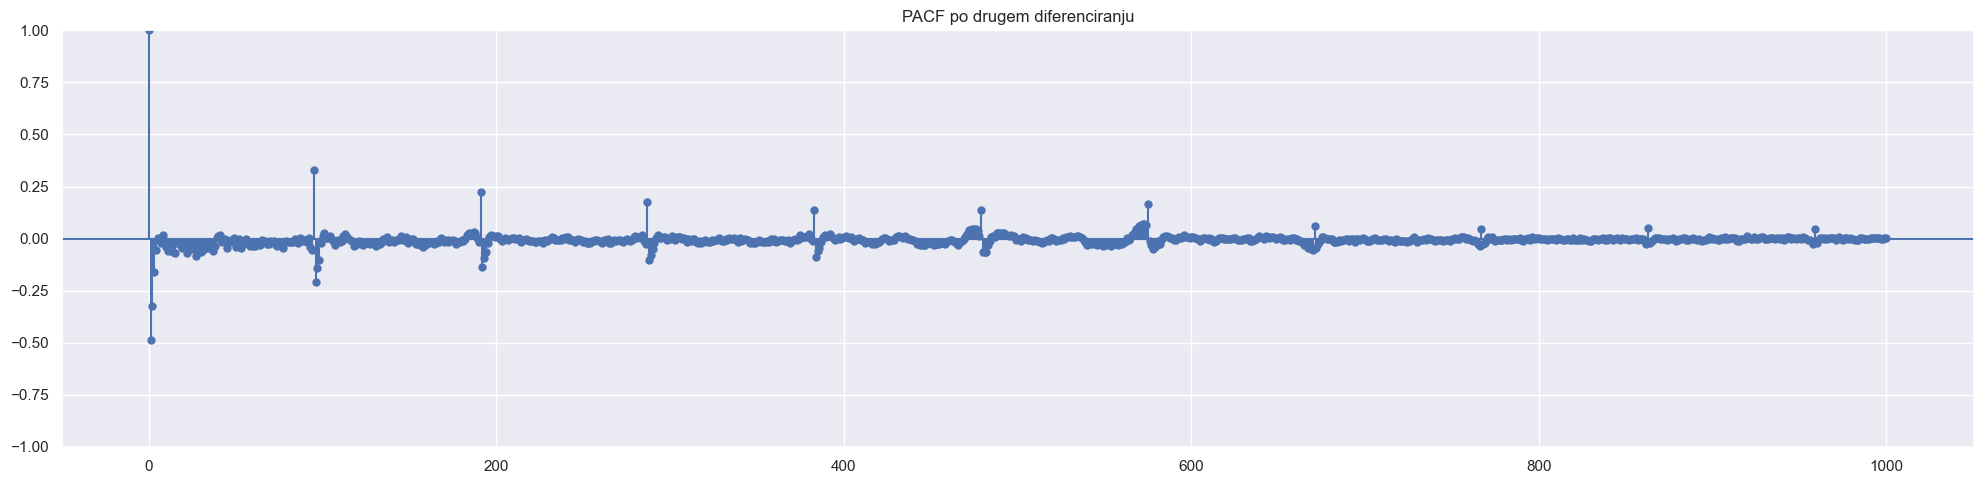

In [25]:
tsaplots.plot_pacf(ts_diff_2, lags=1000, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju')

Text(0.5, 1.0, 'PACF po drugem diferenciranju, zoženo')

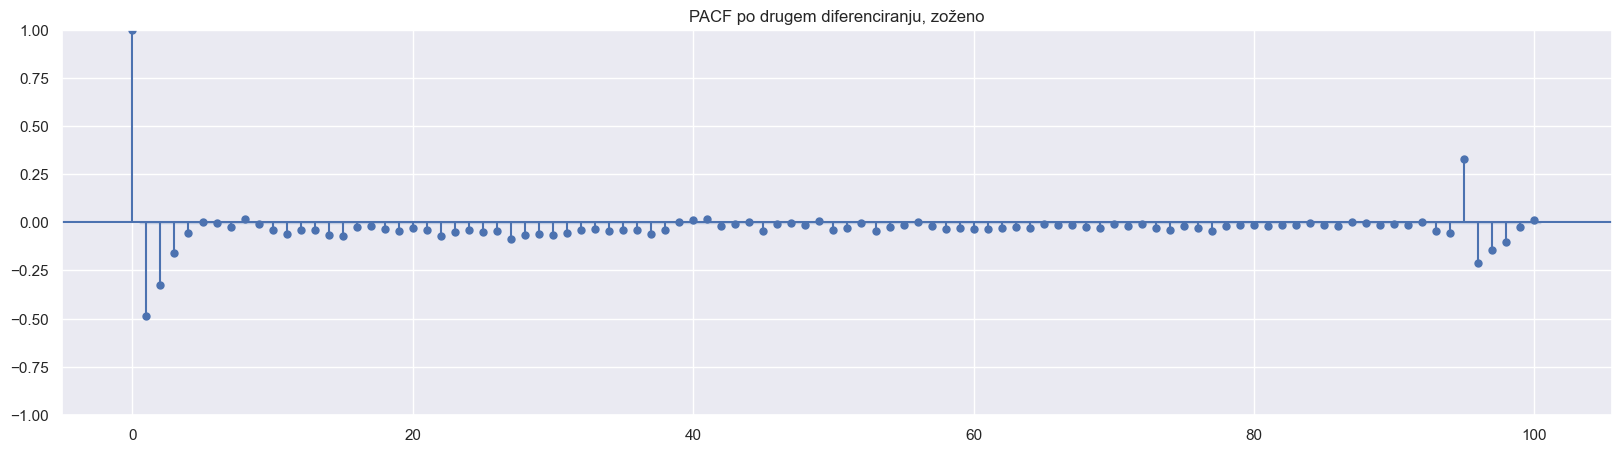

In [27]:
tsaplots.plot_pacf(ts_diff_2, lags=100, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju, zoženo')

# p je 1, 2, 3 ali 95

In [28]:
preveri_stacionarnost(ts_diff_2)

# vsi testi povedo, da je stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -64.756
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         1.000
Lags                              243
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic              -1501.246
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [55]:
# train data:
train_data = ts_diff['2023-01':'2023-03']
train_data_log = podatki.loc['2023-02':'2023-03', 'log return']

temp_data = podatki.loc['2023-01':'2023-03', 'Temperatura FC']

# test data:
test_data = ts_diff['2023-04-01']
test_data_log = podatki.loc['2023-04-01', 'log return']

test_temp_data = podatki.loc['2023-04-01', 'Temperatura FC']

In [ ]:
# d = 1

In [56]:
model_1 = sm.tsa.statespace.SARIMAX(train_data_log, order=(5,1,4), seasonal_order=(0,1,0,96))
results_1 = model_1.fit()

# 7 min

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


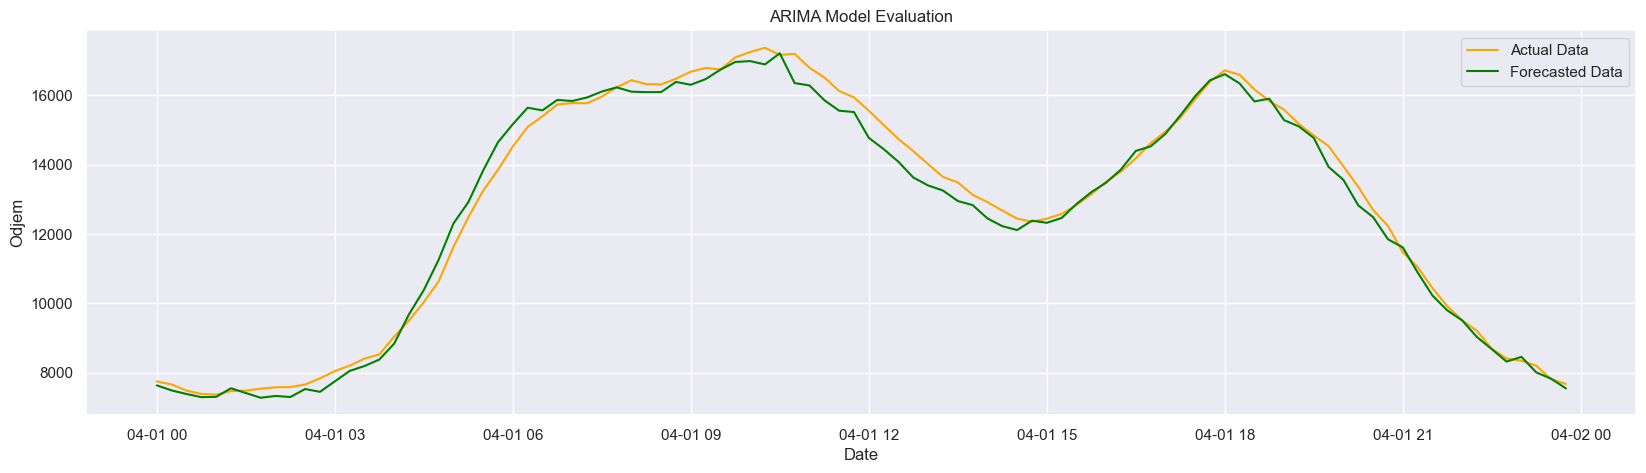

In [87]:
test_forecast = results_1.forecast(steps=96)


# import math

napoved = np.exp(test_forecast + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
napoved

plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='orange')
plt.plot(napoved, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()

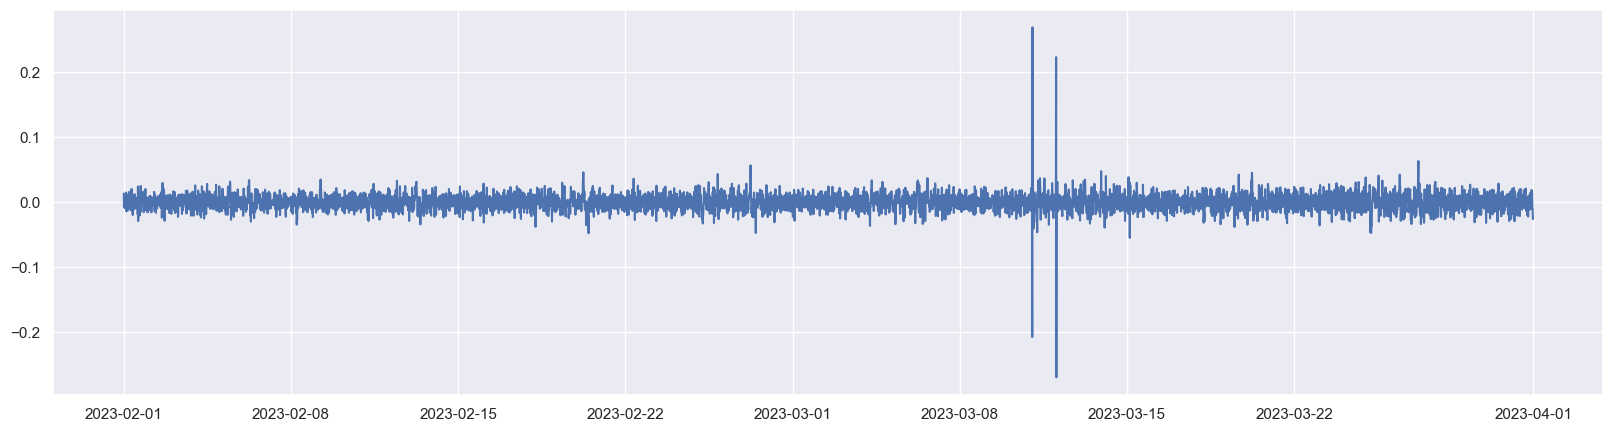

In [107]:
sarima_residuals_1 = results_1.resid
sarima_residuals_1
plt.plot(sarima_residuals_1)

Text(0.5, 1.0, 'ACF SARIMA')

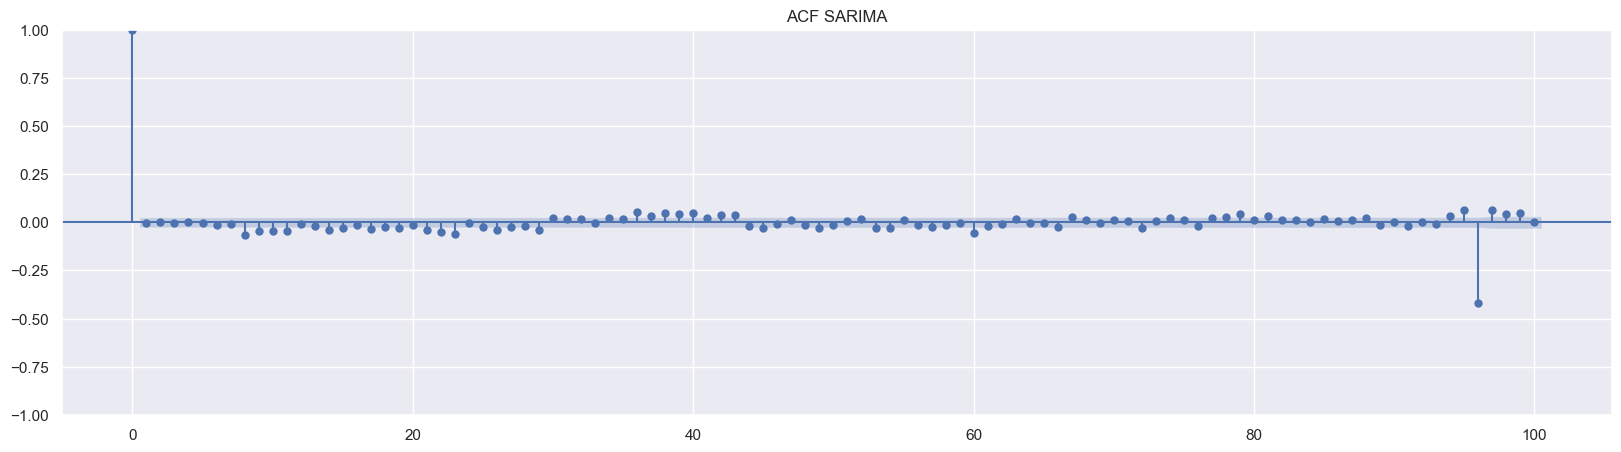

In [91]:
tsaplots.plot_acf(sarima_residuals_1, lags=100)
plt.ylim(-1,1)
plt.title('ACF SARIMA')

Text(0.5, 1.0, 'PACF SARIMA')

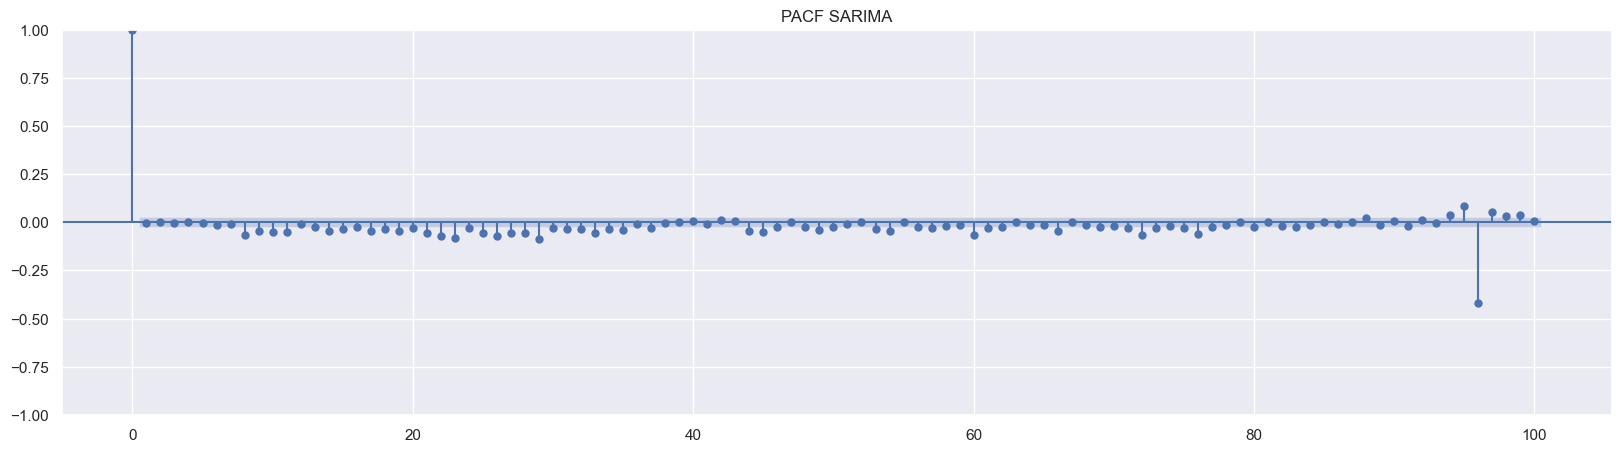

In [92]:
tsaplots.plot_pacf(sarima_residuals_1, lags=100)
plt.ylim(-1,1)
plt.title('PACF SARIMA')

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -16846.361139524914
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16846.36114324046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


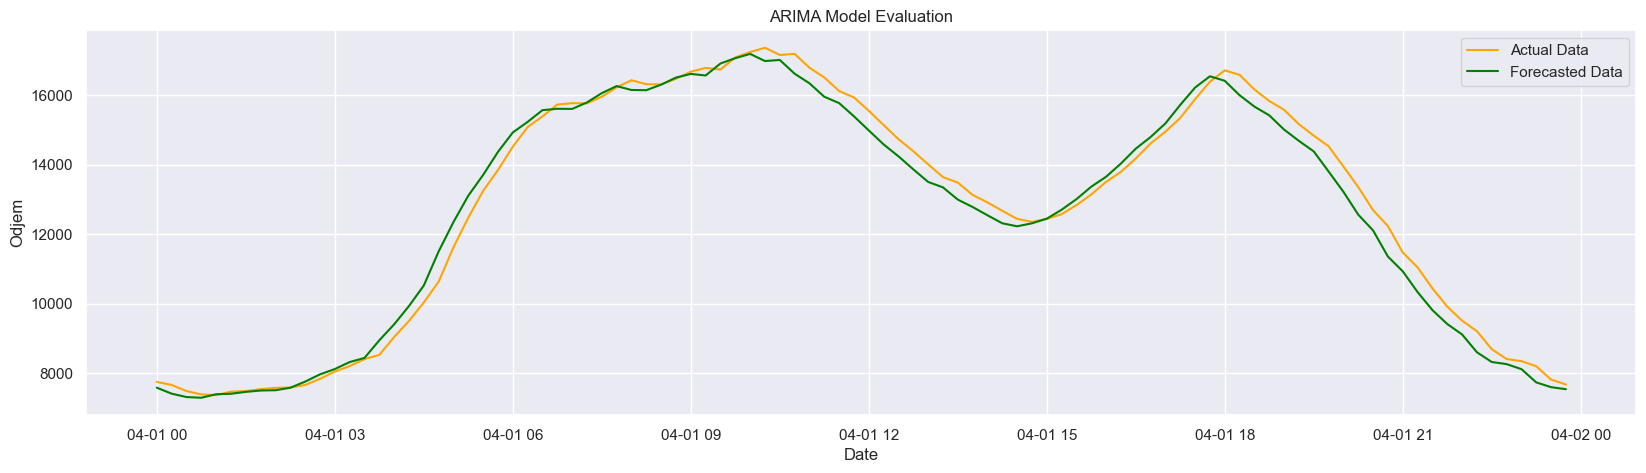

In [117]:
# fit a GARCH(1,1) model on the residuals of the SARIMA model

modelGARCH = arch.arch_model(sarima_residuals_1, mean='Zero', vol='Garch', p=1, q=1)
resultGarch = modelGARCH.fit()
forecastGARCH = resultGarch.forecast(horizon=96)


# združimo SARIMO in GARCH
forecast = test_forecast.mean() + forecastGARCH.variance.values[-1, :]
forecast

forecastDf = pd.DataFrame(forecast, index=test_forecast.index, columns=['Forecast'])
forecastDf

napoved_ARIMA_GARCH = np.exp(forecastDf['Forecast'] + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
napoved_ARIMA_GARCH

plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='orange')
plt.plot(napoved_ARIMA_GARCH, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()



In [121]:
# ERRORS:

def RMSE_MAPE (podatki_OG, napoved):
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

In [123]:
# SARIMA 
[RMSE_SARIMA, MAPE_SARIMA] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved)

[RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved_ARIMA_GARCH)

print(RMSE_SARIMA, MAPE_SARIMA)
print(RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH)


345.93778404627676 2.10478657820608
390.4208141274457 2.5715234851461335
